In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
%matplotlib inline

In [146]:
ads_data = pd.read_csv('ads_data.csv')

In [147]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [148]:
df = ads_data.groupby(['ad_id', 'ad_cost_type', 'platform', 'event'], as_index = False)\
.agg({'user_id': 'count'})

In [149]:
df = df.pivot(index = ['ad_id', 'ad_cost_type', 'platform'], columns = 'event', values = 'user_id')\
.reset_index()

In [150]:
# находим сколько у нас было кликов и просмотров в зависимости от объявления и платформы

In [151]:
df.head()

event,ad_id,ad_cost_type,platform,click,view
0,3,CPC,android,5.0,244.0
1,3,CPC,ios,3.0,147.0
2,3,CPC,web,1.0,99.0
3,2132,CPC,android,1.0,55.0
4,2132,CPC,ios,NaN,26.0


In [152]:
# делаем ttest по платформам

In [153]:
platform_df = df.groupby(['ad_id', 'platform'], as_index = False)\
.agg({'click': 'sum', 'view': 'sum'}).fillna(0)

In [154]:
platform_df = platform_df.query('view > 100 & click > 0')

In [155]:
platform_df.head()

,ad_id,platform,click,view
0,3,android,5.0,244.0
1,3,ios,3.0,147.0
6,2276,android,2.0,703.0
15,4585,android,17.0,224.0
16,4585,ios,24.0,148.0


In [156]:
platform_df = platform_df.assign(ctr = platform_df.click / platform_df.view)

In [157]:
platform_df['ctr_log'] = np.log(platform_df.ctr)

In [158]:
platform_df.head()

,ad_id,platform,click,view,ctr,ctr_log
0,3,android,5.0,244.0,0.020492,-3.887730
1,3,ios,3.0,147.0,0.020408,-3.891820
6,2276,android,2.0,703.0,0.002845,-5.862210
15,4585,android,17.0,224.0,0.075893,-2.578433
16,4585,ios,24.0,148.0,0.162162,-1.819158


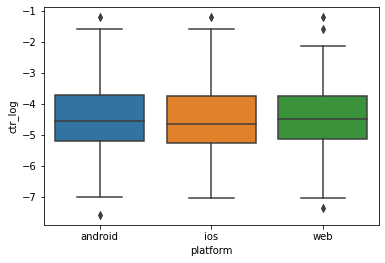

In [161]:
sns.boxplot(x = 'platform', y = 'ctr_log', data = platform_df)

In [164]:
platform_df.groupby('platform', as_index = False).agg({'ctr': 'median'})

,platform,ctr
0,android,0.010695
1,ios,0.009554
2,web,0.011213


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


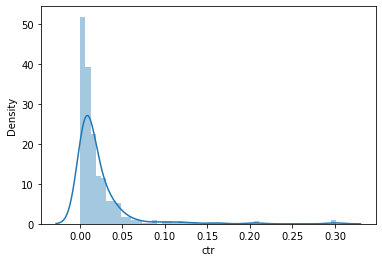

In [165]:
sns.distplot(platform_df.ctr)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


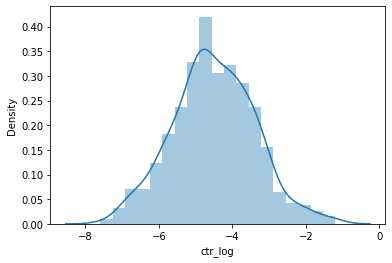

In [166]:
sns.distplot(platform_df.ctr_log)

In [200]:
platform_df.groupby('platform', as_index = False).agg({'ctr': 'median'})

,platform,ctr
0,android,0.010695
1,ios,0.009554
2,web,0.011213


In [201]:
# как сделать ттест если у нас больше 2-x групп?

In [202]:
f_oneway(platform_df[platform_df.platform == 'web'].ctr_log,
        platform_df[platform_df.platform == 'android'].ctr_log,
        platform_df[platform_df.platform == 'ios'].ctr_log)

F_onewayResult(statistic=0.12221144552264535, pvalue=0.884985296331977)

In [203]:
# никаких стат значимых различий нет

In [167]:
# ====================================================================================================

In [168]:
cost_type_df = df.groupby(['ad_id', 'ad_cost_type'], as_index = False)\
.agg({'click': 'sum', 'view': 'sum'}).fillna(0)

In [169]:
# CPC (Cost per Click) — это модель оплаты, при которой рекламодатель платит за каждый клик по его рекламе
# CPM (Cost per Mille) — это модель оплаты, где рекламодатель платит за каждую тысячу показов его объявления

In [170]:
cost_type_df.head()

,ad_id,ad_cost_type,click,view
0,3,CPC,9.0,490.0
1,2132,CPC,1.0,95.0
2,2276,CPC,2.0,1454.0
3,2475,CPM,0.0,132.0
4,2643,CPM,3.0,286.0


In [171]:
# мы теперь знаем про каждое объявление и тип его оплаты

In [172]:
# CTR (Click-Through Rate) — это процентное соотношение количества кликов по объявлению к его показам

In [173]:
cost_type_df = cost_type_df.assign(ctr = cost_type_df.click / cost_type_df.view)

In [174]:
# сделаем что-то типо сортировки, потому что, наверное, не стоит учитывать объявления и рекламу где мало данных

In [175]:
cost_type_df = cost_type_df.query('view > 100 & click > 0')

In [176]:
cost_type_df

,ad_id,ad_cost_type,click,view,ctr
0,3,CPC,9.0,490.0,0.018367
2,2276,CPC,2.0,1454.0,0.001376
4,2643,CPM,3.0,286.0,0.010490
5,4585,CPC,53.0,476.0,0.111345
6,4877,CPC,5.0,2160.0,0.002315
...,...,...,...,...,...
350,121941,CPM,1.0,640.0,0.001563
351,121943,CPC,15.0,1722.0,0.008711
352,122042,CPM,1.0,155.0,0.006452
353,122063,CPM,1.0,260.0,0.003846


In [177]:
# теперь посмотрим что у нас происходит с данными с помощью визуализации

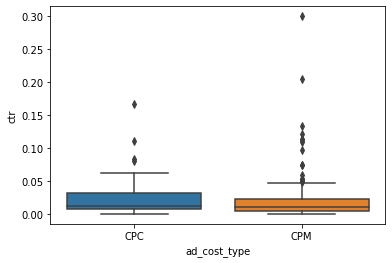

In [178]:
sns.boxplot(x = 'ad_cost_type', y = 'ctr', data = cost_type_df)

In [179]:
# мы видим, что у нас график приплюснутый и тд. Данные у нас ассиметричные

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


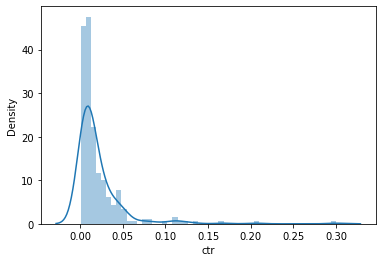

In [180]:
sns.distplot(cost_type_df.ctr)

In [181]:
# что делать? данные у нас распределены не нормально

In [182]:
cost_type_df.groupby('ad_cost_type', as_index = False).agg({'ctr': 'median'})

,ad_cost_type,ctr
0,CPC,0.012019
1,CPM,0.010490


In [183]:
# видим что различия в медианах есть
# эта разница стат значима или вписывается в рандомный шум?

In [184]:
cost_type_df.groupby('ad_cost_type', as_index = False).agg({'ctr': 'mean'})

,ad_cost_type,ctr
0,CPC,0.024107
1,CPM,0.019467


In [185]:
# на помощь нам придет t-test

In [199]:
# используем логарифмы - чтобы сгладить наши данные (см. график логарифмов) и получить нормальное распределение

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


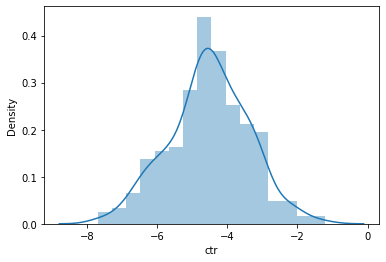

In [187]:
sns.distplot(np.log(cost_type_df.ctr))

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


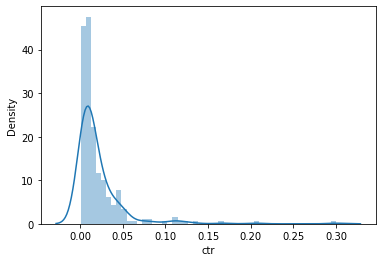

In [188]:
sns.distplot(cost_type_df.ctr)

In [189]:
# создадим ctr log 

In [190]:
cost_type_df['ctr_log'] = np.log(cost_type_df.ctr)

In [191]:
cost_type_df

,ad_id,ad_cost_type,click,view,ctr,ctr_log
0,3,CPC,9.0,490.0,0.018367,-3.997181
2,2276,CPC,2.0,1454.0,0.001376,-6.588926
4,2643,CPM,3.0,286.0,0.010490,-4.557380
5,4585,CPC,53.0,476.0,0.111345,-2.195126
6,4877,CPC,5.0,2160.0,0.002315,-6.068426
...,...,...,...,...,...,...
350,121941,CPM,1.0,640.0,0.001563,-6.461468
351,121943,CPC,15.0,1722.0,0.008711,-4.743191
352,122042,CPM,1.0,155.0,0.006452,-5.043425
353,122063,CPM,1.0,260.0,0.003846,-5.560682


In [192]:
cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log

0     -3.997181
2     -6.588926
5     -2.195126
6     -6.068426
7     -3.704823
11    -5.831882
13    -4.018549
14    -4.766438
15    -2.523226
17    -4.884694
19    -6.898715
20    -4.655863
21    -4.139159
25    -3.061386
31    -3.212187
32    -3.459466
34    -3.356746
37    -6.362597
52    -4.897840
54    -4.826712
82    -4.801285
106   -4.525405
117   -5.284218
120   -4.695011
125   -1.787876
151   -4.882802
155   -3.107436
228   -3.791737
245   -4.586242
254   -4.686952
255   -4.881286
256   -3.309630
258   -3.222790
259   -3.530553
266   -5.755215
270   -3.367296
279   -3.672496
284   -2.981276
295   -2.484907
300   -4.337291
301   -4.424847
304   -4.789573
306   -4.382027
321   -3.719651
322   -5.499215
332   -4.465908
333   -3.258097
334   -4.409763
335   -7.006695
336   -4.421247
337   -6.312944
340   -7.013016
348   -2.768245
351   -4.743191
354   -3.688379
Name: ctr_log, dtype: float64

In [193]:
cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr_log

4     -4.557380
8     -3.751854
9     -4.143135
10    -3.392269
12    -4.727388
         ...   
346   -3.533687
349   -4.424847
350   -6.461468
352   -5.043425
353   -5.560682
Name: ctr_log, Length: 247, dtype: float64

In [194]:
# делаем ттест

In [195]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr_log,
         cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr_log)

Ttest_indResult(statistic=-1.1407296867039143, pvalue=0.25489224816951805)

In [196]:
# pvalue=0.25489224816951805 - означает что если бы была верна нулевая гипотеза, то вероятность получить те же самые различия 
# составила бы 25% - это много. Мы не смогли подвердить гипотезу о том что ctr существенно отличаются друг от друга

In [197]:
ttest_ind(cost_type_df[cost_type_df.ad_cost_type == 'CPM'].ctr,
         cost_type_df[cost_type_df.ad_cost_type == 'CPC'].ctr)

Ttest_indResult(statistic=-1.0366111047153586, pvalue=0.3007519549674309)

In [198]:
# то же самое